# Importation et Visualisation des données

In [36]:
# Librairies et modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import datetime as dt
import itertools
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

In [38]:
#Importation de la base de données
df = pd.read_csv("../donnees/bases_connus.csv")
df.sample(n=3,random_state=14)

C:\Users\camil\AppData\Local\Temp\ipykernel_3716\1900866677.py:2: DtypeWarning: Columns (10,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../donnees/bases_connus.csv")


,region_cri,date_debloc_avec_crd,DAT_VALIDE_ACCORD_CRI,nb_pret,TOP_CONNU_BRP,TOP_SCI_BRP,ASU_BIEN_FIN_BRP,NAT_BIEN_FIN_BRP,NBR_INT_BRP,NBR_TOT_COEMPR_CRI,...,Mt_credit_nb_ans_rev_prof,Epargne_nb_ans_rev_prof,rentabilite_loc,financement_tot,quotite,top_locatif,top_pret_int_ext,top_autre_pret_int,top_autre_pret_ext,top_pers_seule
52915,ILE DE FRANCE,201603,27-Aug-15,1,1,0,10,20,2,1,...,4.933149,0.017082,NaN,392244.55,1.027166,0,0,0,0,0
8787,PACA,201407,12-Jun-14,1,1,0,20,10,2,1,...,1.634442,0.049699,NaN,135000.00,0.950704,0,1,0,0,0
92595,AUVERGNE,201607,16-Jun-16,2,1,0,10,20,2,1,...,2.649658,0.351810,NaN,191300.00,0.524541,0,1,0,0,0


In [39]:
# Dimension de la base des données 
print(f"La base de données fait {df.shape[0]} lignes et {df.shape[1]} colonnes")

La base de données fait 163614 lignes et 123 colonnes


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163614 entries, 0 to 163613
Columns: 123 entries, region_cri to top_pers_seule
dtypes: float64(72), int64(40), object(11)
memory usage: 153.5+ MB


defaut_36mois
0    162555
1      1059
dtype: int64


<AxesSubplot:ylabel='defaut_36mois'>

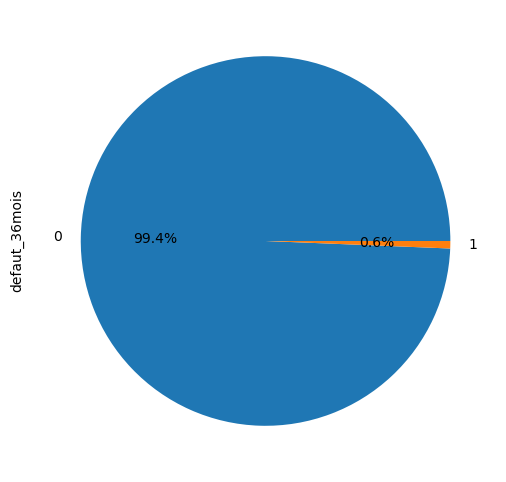

In [41]:
# Répartition de la variable à modéliser
print(df.groupby(['defaut_36mois']).size())

# Distribution par variable
plt.figure(figsize=(8, 6))
df["defaut_36mois"].value_counts().plot.pie(autopct = lambda x: str(round(x, 1)) + '%')

**_Nous remarquons que nous avons une faible proportion de défaut dans la base (0,6%)._**

# Construction de la base d'études

### Vérification de la base des données

In [42]:
# Vérification du type des variables
col_categoricals = []
col_numericals = []

for col in df.columns :
    if df[col].dtypes == 'float64' or df[col].dtypes == 'int64':
        col_numericals.append(col)
    else :
        col_categoricals.append(col)

print(f"Liste des colonnes catégorielles :\n{col_categoricals}")
print(f"\nListe des colonnes numériques :\n{col_numericals}")

Liste des colonnes catégorielles :
['region_cri', 'DAT_VALIDE_ACCORD_CRI', 'COD_POSTAL_BIEN_CRI', 'CODPAY_BIEN_CRI', 'NAT_INT_MAX_BRP', 'TYP_CNT_TRA_MAX_BRP', 'CODPAY_NAT_EMPRUNTEUR_CRI', 'CODTYP_CRT_TRAVAIL_CRI', 'COD_TYPE_MARCHE_CRI', 'IND_INCIDENT_BDF_CRI', 'DEPARTEMENT_CRI']

Liste des colonnes numériques :
['date_debloc_avec_crd', 'nb_pret', 'TOP_CONNU_BRP', 'TOP_SCI_BRP', 'ASU_BIEN_FIN_BRP', 'NAT_BIEN_FIN_BRP', 'NBR_INT_BRP', 'NBR_TOT_COEMPR_CRI', 'TOP_GARANTIE_CL', 'CODTYPE_PROJET_CRI', 'COD_CPPOP_CRI', 'COD_ETA_BIEN_CRI', 'COD_USAGE_BIEN_CRI', 'BEST_APPORT_MT_BRP', 'BEST_APPORT_TX_BRP', 'PCT_APPORT_PERS_CRI', 'PCT_ENDETTMT_CRI', 'TOP_ETR_BRP', 'TOP_PRET_RELAIS_BRP', 'TX_APPORT_HF_AT_BRP', 'TX_APPORT_HF_HT_BRP', 'TX_APPORT_TF_AT_BRP', 'TX_APPORT_TF_HT_BRP', 'TX_APPORT_BRP', 'TX_APPORT_AGENCE_BRP', 'TX_FINANCEMENT_BRP', 'TX_FINANCEMENT_AGENCE_BRP', 'FINANCEMENT_LT_BRP', 'FINANCEMENT_PR_BRP', 'TX_APPORT_SE_BRP', 'LTV_OCTROI_BRP', 'LTV_ACPR_BRP', 'TOP_SURFINANCEMENT_BRP', 'top_exis

**_Nous constatons que certaines variables ne sont pas au bon format. Il s'agit de variables dates qui ne sont pas reconnues comme tel ou des variables catégorielles qui sont prises en compte comme des variables numériques. Il conviendra de les mettre au bon format._**

In [43]:
#Date de déblocage
df["date_debloc_avec_crd"] = pd.to_datetime(df["date_debloc_avec_crd"], format='%Y%m')

**_Nous vérifions également pour chaque variable categorielle, le nombre de modalités qu'elle contient. Etant donné le grand nombre de variables que nous avons, une méthode est utilisée afin d'afficher les résultats pour toutes les variables sans exception._**

In [44]:
# Nombres de modalités par variable
for var in df.select_dtypes('object'):
    print(var,":", df[var].nunique())
for var in df.select_dtypes('int'):
    print(var,":", df[var].nunique())

region_cri : 15
DAT_VALIDE_ACCORD_CRI : 1580
COD_POSTAL_BIEN_CRI : 11050
CODPAY_BIEN_CRI : 39
NAT_INT_MAX_BRP : 135
TYP_CNT_TRA_MAX_BRP : 13
CODPAY_NAT_EMPRUNTEUR_CRI : 130
CODTYP_CRT_TRAVAIL_CRI : 13
COD_TYPE_MARCHE_CRI : 3
IND_INCIDENT_BDF_CRI : 2
DEPARTEMENT_CRI : 213
nb_pret : 6
TOP_CONNU_BRP : 1
TOP_SCI_BRP : 2
ASU_BIEN_FIN_BRP : 7
NAT_BIEN_FIN_BRP : 15
NBR_INT_BRP : 7
NBR_TOT_COEMPR_CRI : 6
TOP_GARANTIE_CL : 2
CODTYPE_PROJET_CRI : 15
COD_CPPOP_CRI : 13
COD_ETA_BIEN_CRI : 12
COD_USAGE_BIEN_CRI : 7
PCT_APPORT_PERS_CRI : 114
TOP_ETR_BRP : 2
TOP_PRET_RELAIS_BRP : 2
TOP_SURFINANCEMENT_BRP : 2
top_exist_conso_revo_BRP : 2
NBR_DUREE_TOT_PRET_CRI : 322
AGE_INT_MAX_BRP : 81
ANC_OCC_LOG_ACT_BRP : 71
ANC_PROF_MAX_BRP : 61
NBR_ENF_CHAR_BRP : 10
NBR_AUT_CHAR_BRP : 13
TOP_ASC_DESC_BRP : 2
QUA_INT_1_BRP : 4
QUA_INT_MAX_BRP : 4
ROL_INT_MAX_BRP : 2
NBR_AGE_CLIENT_CRI : 80
NBR_ENF_ACHARGE_CRI : 10
NBR_OCCUP_CRI : 25
defaut_36mois : 2
TOP_BIEN_FR_CRI : 2
TOP_NAT_FR_CRI : 2
ID : 163614
top_locatif :

**_Nous constatons la présence d'une variable à une seule modalité (TOP_CONNU_BRP). Cette variable n'apporte aucune information et doit donc être supprimée du jeu de données._**

In [45]:
#Vérification de doublons
df['ID'].nunique()==df.shape[0]

True

**_La variable ID nous confirme que notre base de données ne contient pas de doublons. N'étant également pas informatif, nous la supprimons du jeu de données. Conformément aux instructions reçues, nous allons également supprimer la variable TOP_GARANTIE_CL. La variable TOP_CONNU_BRP doit également être supprimée._**

In [46]:
df = df.drop(["TOP_CONNU_BRP"], axis=1).drop(["ID"], axis=1).drop(["TOP_GARANTIE_CL"], axis=1)
df.shape

(163614, 120)

### Nettoyage des données (valeurs manquantes, extrêmes, …)

<AxesSubplot:>

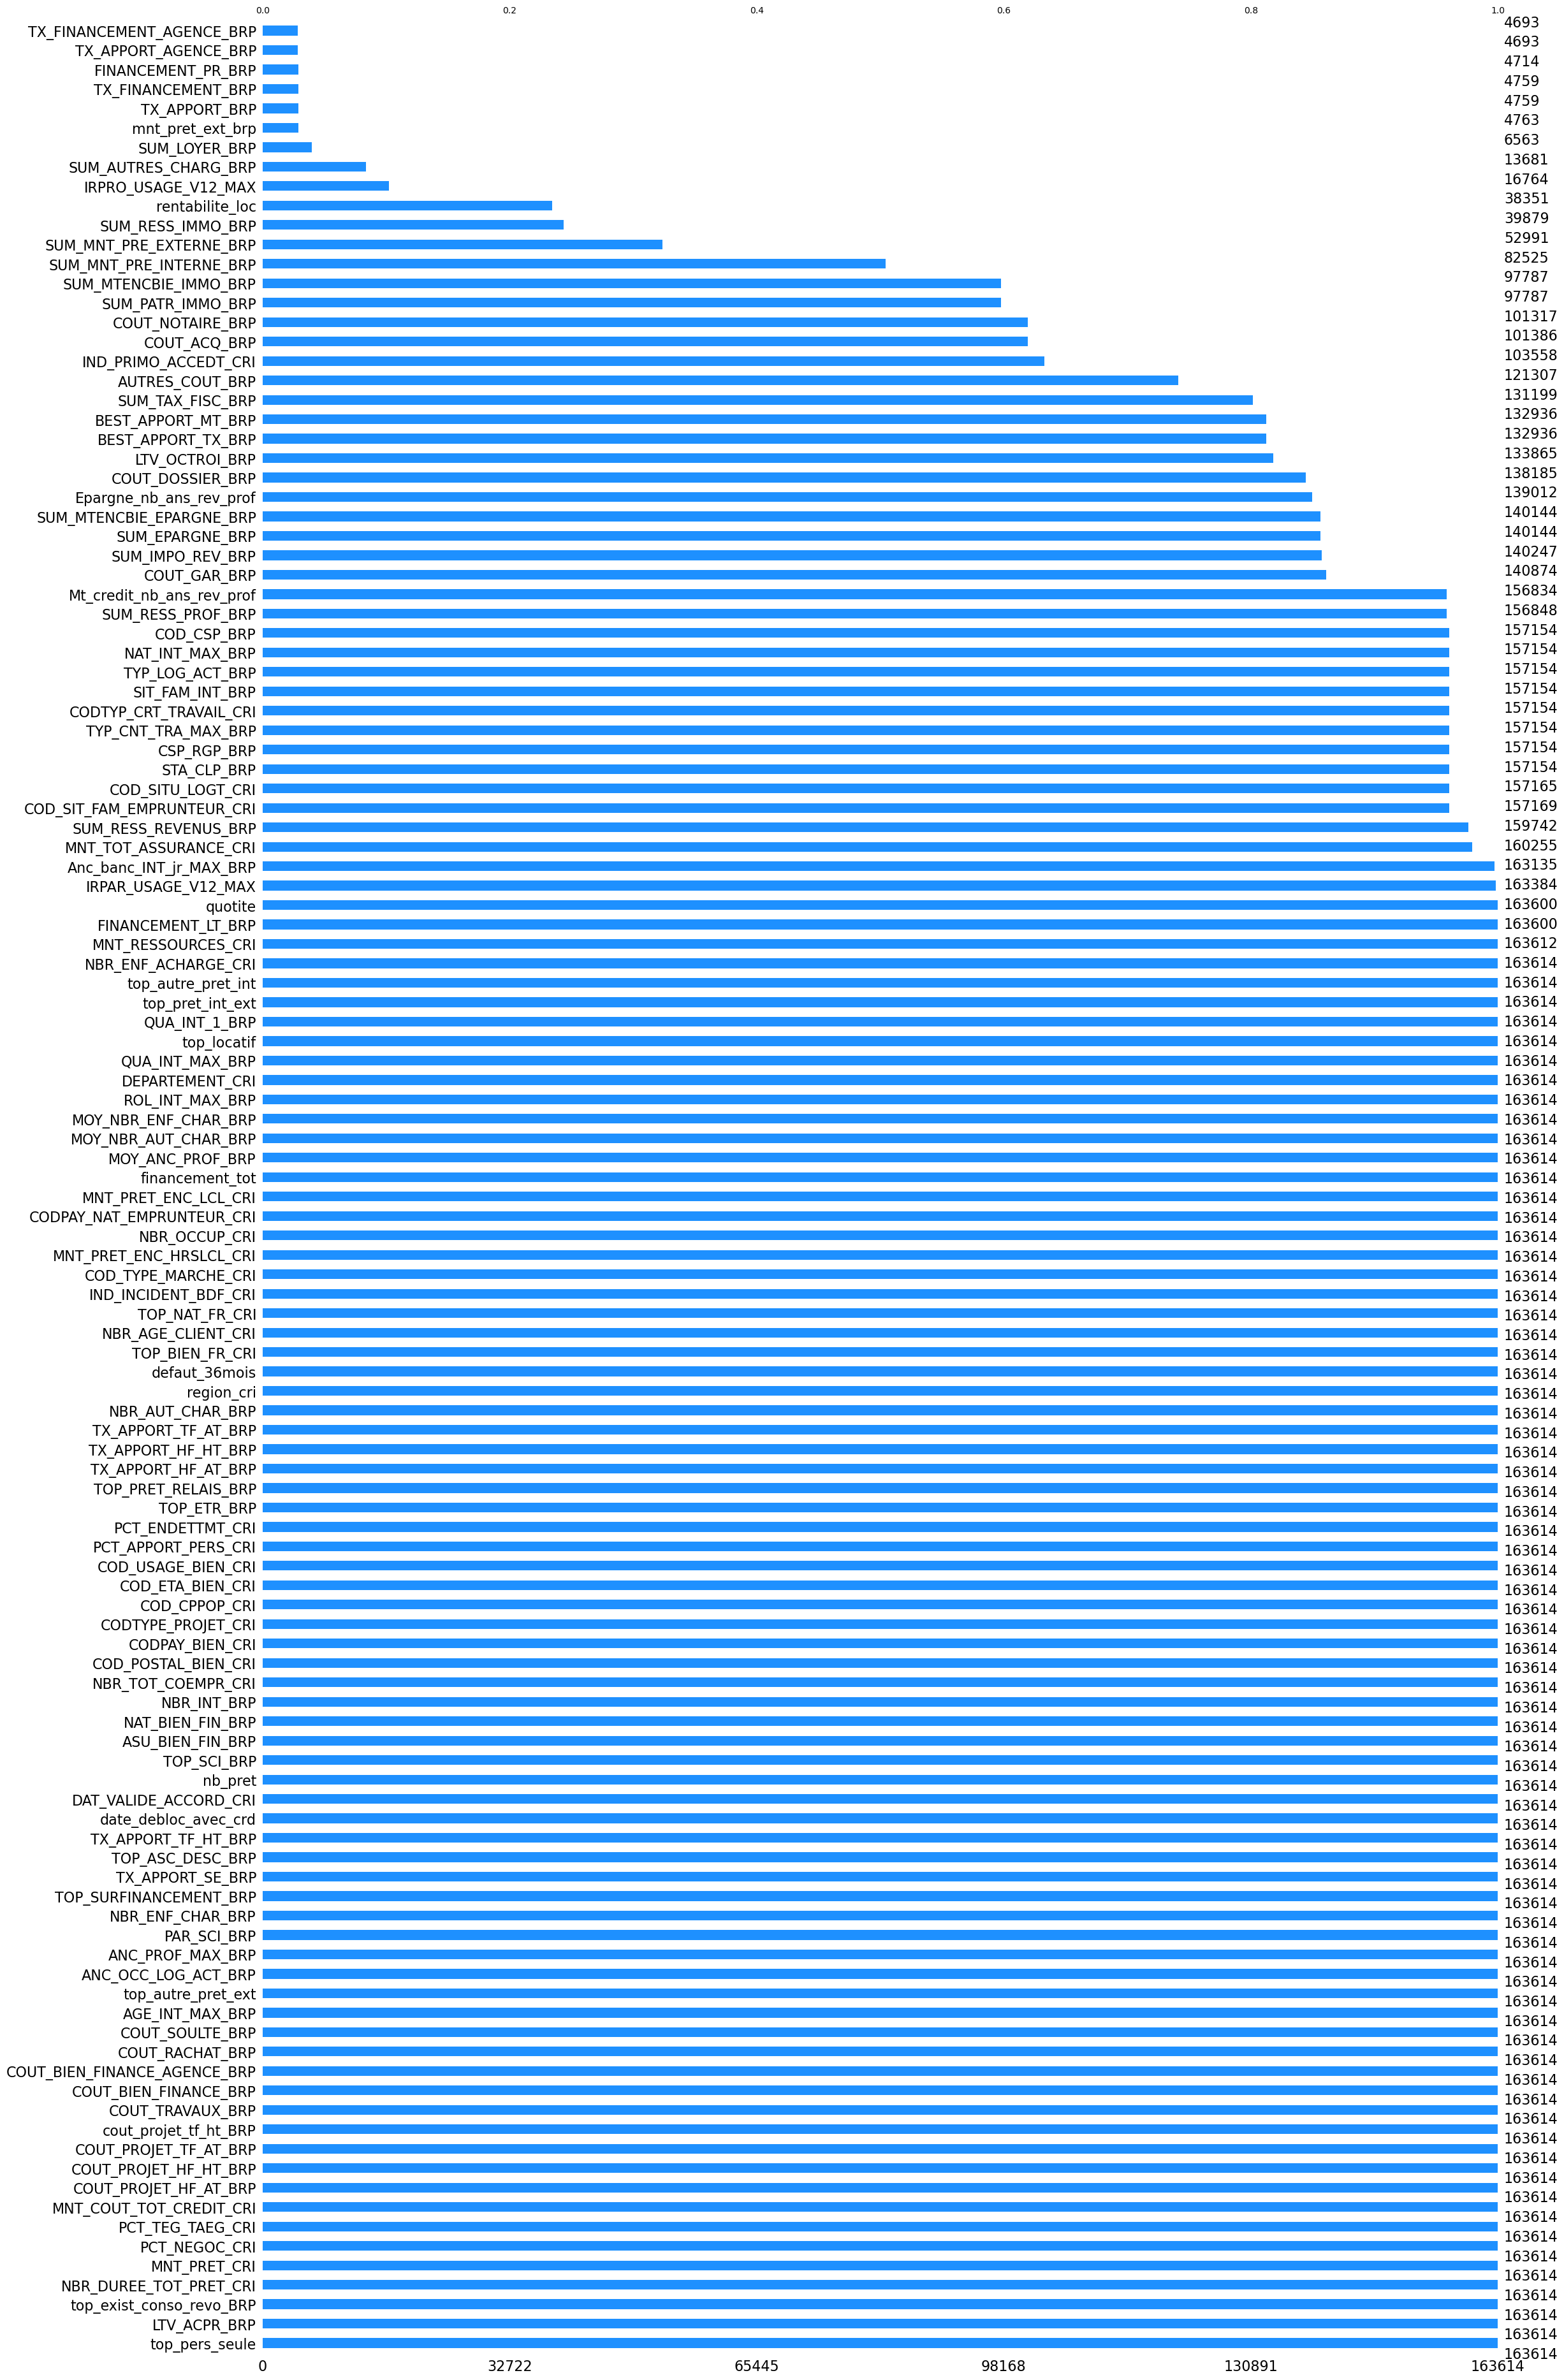

In [47]:
# Taux de valeurs présentes par variable
msno.bar(df, color="dodgerblue", sort="descending")

**_Nous constatons la présence de valeurs manquantes dans la base de données. Cependant, nous ne pouvons pas imputer les valeurs manquantes sans les avoir comprises au préalable. En effet, pour un bon traitement des valeurs manquantes et un bon nettoyage des données, il est important de comprendre chaque variable. A ce stade, une première sélection des variables est utile à la création de notre base d'analyse._**

In [48]:
taux_de_NAN = round((df[df.columns[df.isna().sum()>0]].isna().sum()*100/df.shape[0]).sort_values(ascending=False),5)
taux_de_NAN

TX_APPORT_AGENCE_BRP          97.13166
TX_FINANCEMENT_AGENCE_BRP     97.13166
FINANCEMENT_PR_BRP            97.11883
TX_APPORT_BRP                 97.09132
TX_FINANCEMENT_BRP            97.09132
mnt_pret_ext_brp              97.08888
SUM_LOYER_BRP                 95.98873
SUM_AUTRES_CHARG_BRP          91.63825
IRPRO_USAGE_V12_MAX           89.75393
rentabilite_loc               76.56007
SUM_RESS_IMMO_BRP             75.62617
SUM_MNT_PRE_EXTERNE_BRP       67.61218
SUM_MNT_PRE_INTERNE_BRP       49.56116
SUM_MTENCBIE_IMMO_BRP         40.23311
SUM_PATR_IMMO_BRP             40.23311
COUT_NOTAIRE_BRP              38.07559
COUT_ACQ_BRP                  38.03342
IND_PRIMO_ACCEDT_CRI          36.70591
AUTRES_COUT_BRP               25.85781
SUM_TAX_FISC_BRP              19.81187
BEST_APPORT_TX_BRP            18.75023
BEST_APPORT_MT_BRP            18.75023
LTV_OCTROI_BRP                18.18243
COUT_DOSSIER_BRP              15.54207
Epargne_nb_ans_rev_prof       15.03661
SUM_EPARGNE_BRP          

<AxesSubplot:>

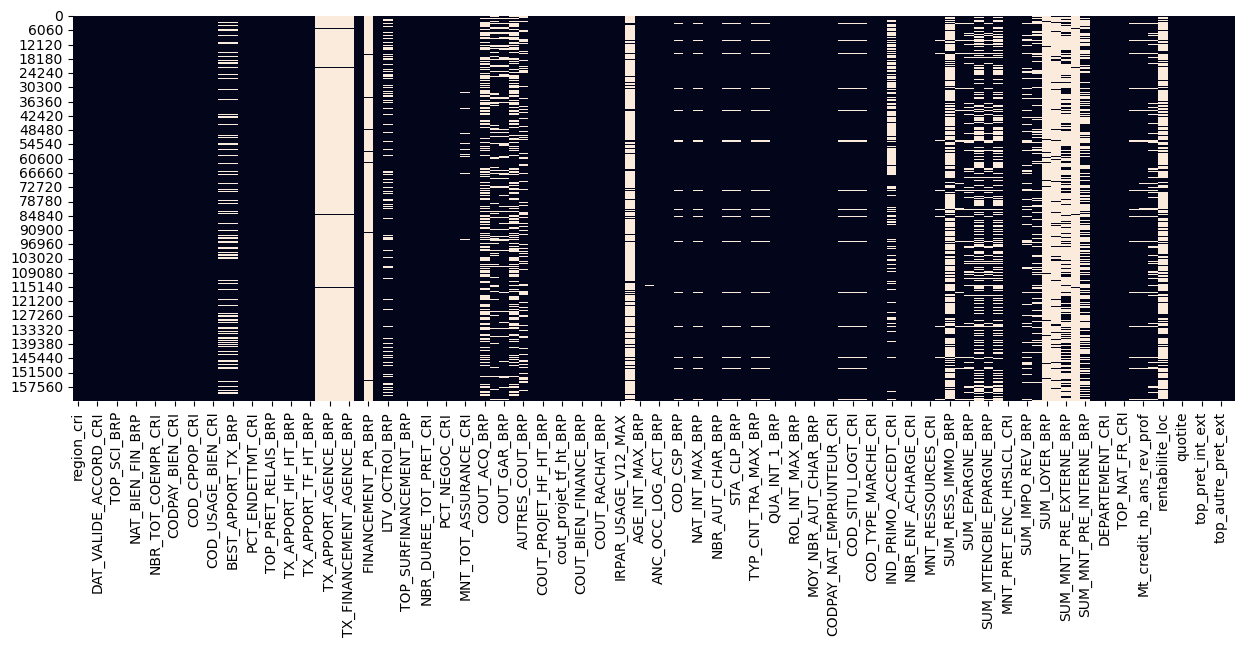

In [49]:
# Visualisation des valeurs manquantes
plt.figure(figsize=(15,5))
sns.heatmap(df.isna(), cbar=False)
# Plus à la verticale c'est blanc, plus cette variable contient des valeurs manquantes

**Le graphique ci-dessus nous donne une vision des valeurs manquantes par variables et par lignes. Plus la zone blanche de la verticale est blanche, plus la variable correspondante contient des valeurs manquantes. Il en est de même pour l'horizontale qui donne une visualisation des valeurs manqauntes pour une ligne. Nous pouvons constater que certaines observations contiennent des valeurs manquantes pour des memes observations. En observant les valeurs manquantes suivant l'axe horizontal, nous constatons une certaine linéarité ou alignement des valeurs manquantes. Cette observations laisse présager que les valeurs manquantes de certaines variables ne sont pas aléatoires. En effet, si les valeurs manquantes de notre base de données étaient aléatoires, notre graphique aurait été semblable à un nuage de points blancs et noirs. Ce qui n'est pas le cas ici. Nous avons une représentation par blocs. La suite de notre analyse confirmera ou réfutera notre constat.** 

<AxesSubplot:>

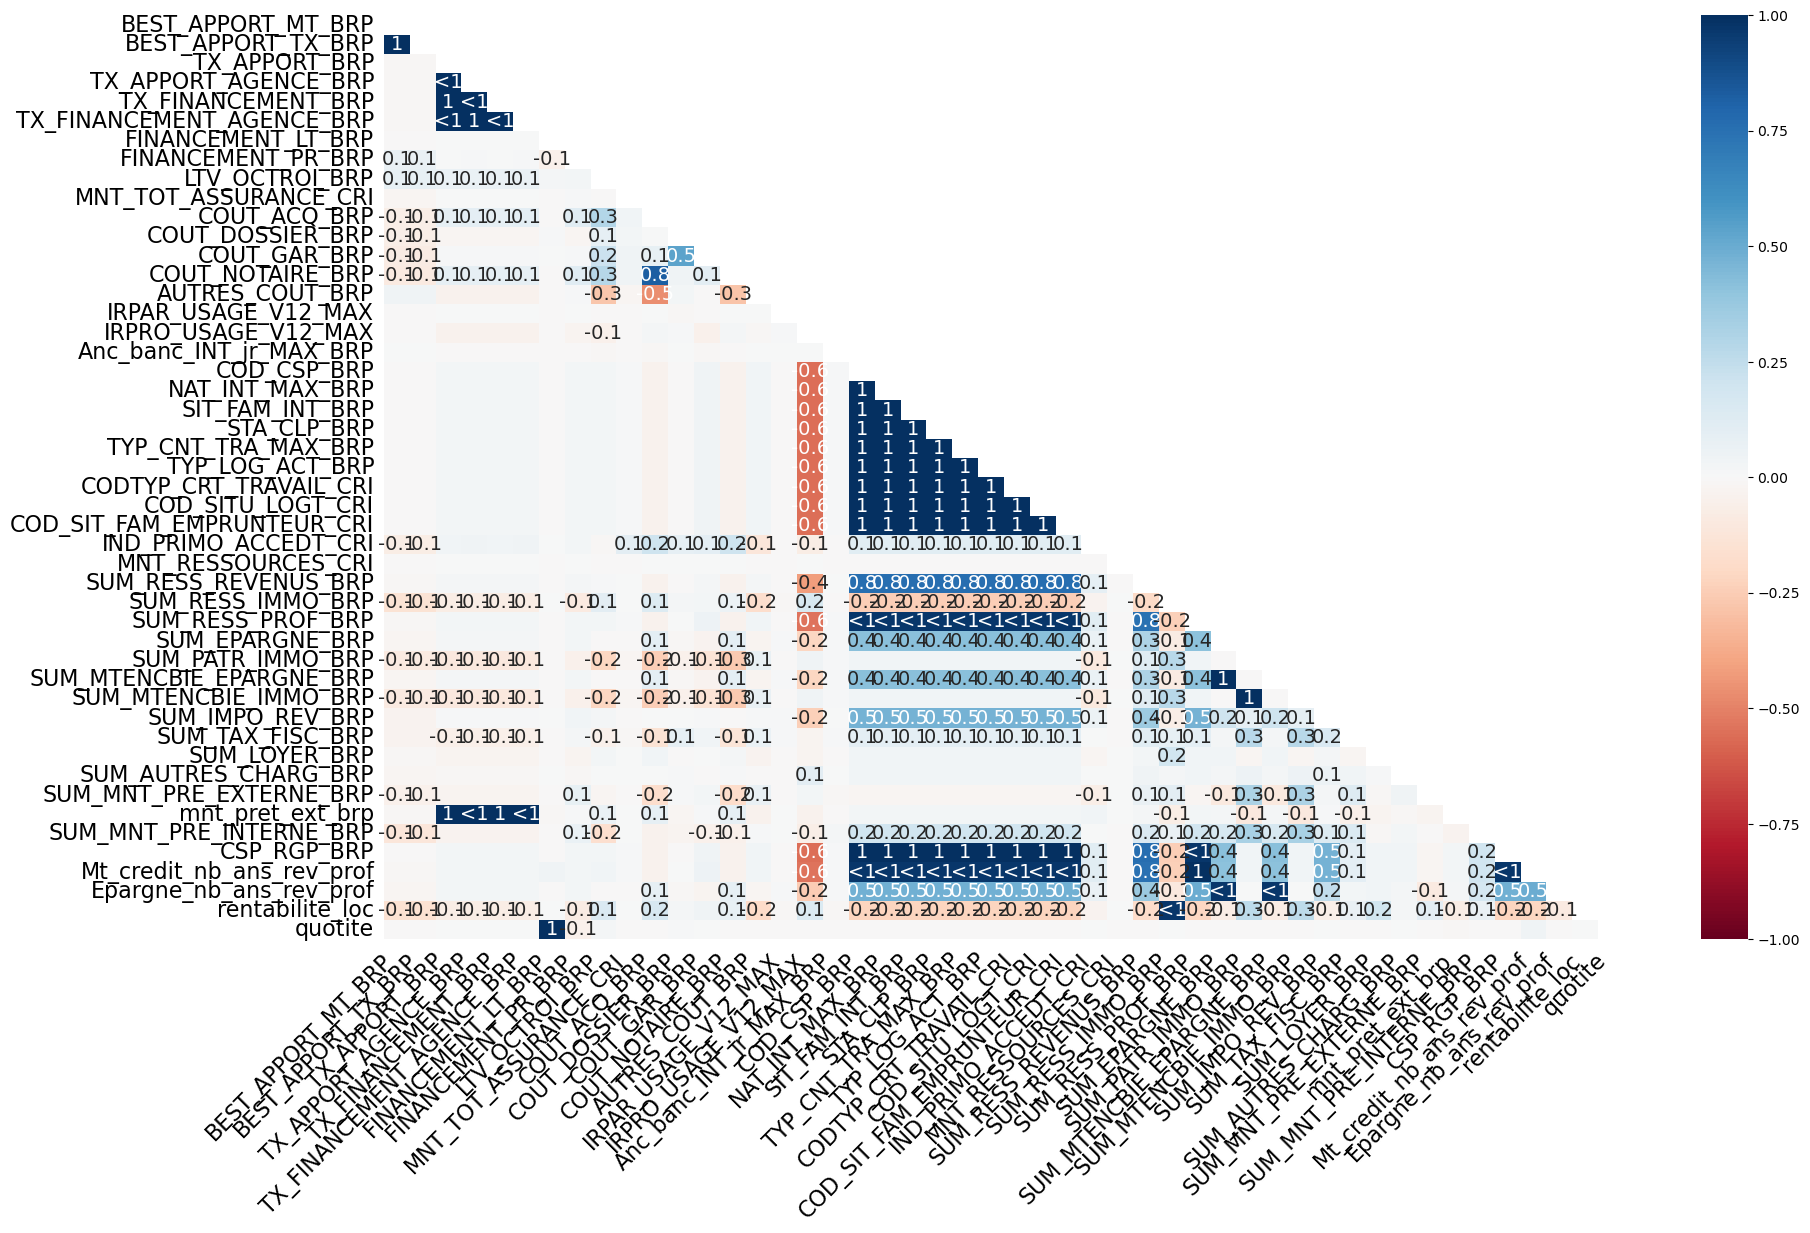

In [50]:
# Corrélation des valeurs manquantes des variables
msno.heatmap(df)

Ce graphique affiche la corrélation entre les valeurs manquantes des variables. Cette corrélation est comprise entre -1 et 1.

-1 - La corrélation négative exacte signifie que si la valeur d’une variable est présente, la valeur des autres variables est définitivement absente.
0 - Aucune corrélation ne signifie que les valeurs des variables présentes ou absentes n’ont aucun effet les unes sur les autres.
1 - La corrélation positive exacte représente que si la valeur d’une variable est présente, la valeur de l’autre est définitivement présente.

Autres explications 

Une valeur proche de -1 signifie que si une variable apparaît, il est fort probable que l`autre variable soit manquante .
Une valeur proche de 0 signifie qu`il n`y a pas dépendance entre l`occurrence de valeurs manquantes ‚Äã‚Äãode deux variables.
Une valeur proche de 1 signifie que si une variable apparaît, alors l`autre variable est très probablement présente

**Supression de valeurs manquantes avec plus de 50% de valeurs manquantes**

In [51]:
# Suppression des colonnes à plus de 50 %
col_to_del = df[df.columns[df.isna().sum()/df.shape[0] >=0.5]].columns
print(f"On va supprimer {len(col_to_del)} variables")
print(f'Les variables supprimées sont : {col_to_del}')

On va supprimer 12 variables
Les variables supprimées sont : Index(['TX_APPORT_BRP', 'TX_APPORT_AGENCE_BRP', 'TX_FINANCEMENT_BRP',
       'TX_FINANCEMENT_AGENCE_BRP', 'FINANCEMENT_PR_BRP',
       'IRPRO_USAGE_V12_MAX', 'SUM_RESS_IMMO_BRP', 'SUM_LOYER_BRP',
       'SUM_AUTRES_CHARG_BRP', 'SUM_MNT_PRE_EXTERNE_BRP', 'mnt_pret_ext_brp',
       'rentabilite_loc'],
      dtype='object')


Les variables supprimées sont les suivantes :

    - FINANCEMENT_PR_BRP                 Montant du prêt relais
    - mnt_pret_ext_brp                   Montant des prets externes
    - rentabilite_loc                    Rentabilité pour investissement locatif
    - SUM_AUTRES_CHARG_BRP               Somme des autres charges
    - SUM_LOYER_BRP                      Somme des loyers
    - SUM_RESS_IMMO_BRP                  Somme des revenus immobiliers liés au projet de tous les intervenants
    - TX_APPORT_AGENCE_BRP               Taux d'apport avec frais d'agence
    - TX_APPORT_BRP                      Taux d'apport
    - TX_FINANCEMENT_AGENCE_BRP          Taux financement avec frais d'agence
    - TX_FINANCEMENT_BRP                 Taux financement
    - IRPRO_USAGE_V12_MAX                Classe de risque (Professionnels) de l'intervenant principal
    - SUM_MNT_PRE_EXTERNE_BRP            Somme des montants des prets externes
    
Toutes ces valeurs manquantes sont inhérentes à la base de données. On dit qu'elles sont manquantes par construction. Elles sont donc légitimes en raison de la structure de la base de données. En effet, pour ces variables il n'existe des valeurs que si d'autres variables contiennent également des valeurs. On dit que ces variables sont corrélées. Notons également que la variable **Taux d'apport** apparait en doublons dans la base de données.

In [52]:
# Garder les colonnes avec moins de 50% de valeurs manquantes
def keep_some_columns(df_):

    df__ = df_[df_.columns[df_.isna().sum()/df_.shape[0] < 0.5]]

    return df__

df = keep_some_columns(df)

# Dimension de la base des données 
print(f"La base de données fait maintenant {df.shape[0]} lignes et {df.shape[1]} colonnes.")

La base de données fait maintenant 163614 lignes et 108 colonnes.


**_Présélection de variables niveau métier_**

A cette étape, il conviendra de préselectionner des variables d'un point de vue métier. En effet, pour la construction d'un score, il est indéniable d'inclure certaines variables caractéristiques de l'emprunteur, du bien financé et des termes du contrat. Ces variables sont des variables relatives aux critères suivants :
    
    Variables emprunteurs :
        - Epargne
        - Classe de risque (IRPAR)
        - Ancienneté professionnelle
        - Situation socio-professionnelle
        - Contrat de travail
        - Logement actuel
        - Nombre d'enfants à charge
        - Nationalité
        - Existence d'un prêt conso
        - Nature de l'intervenant
    
    Variables projets:
        - Taux d'intérêts
        - LVT octroi
        - Taux d'apport
        - Cout des travaux
        - Nature du projet
        - Etat du bien
        - Durée du prêt
        - Prêts relais
        - Localisation du bien


**_Méthodologie de sélection :_**

Pour chaque critère nous retrouvons plusieurs variables qui y sont rattachées dans la base de données. Une sélection des variables adéquates à chaque critère se fera selon certaines règles que sont : 
- la suppression des doublons
- la non pertinence des valeurs pour une variable
- un nombre important de valeurs manquantes
- un grand nombre de modalités de la variable (par exexmple nationalité car il y a trop de pays)

Pour voir le détail :
- ouvrir le notebook "Première sélection des variables" 
- les fichiers excel : 
    - train_connus.xlsx
    - Dictionnaire de données.xlsx
    - Lexique.xlsx
    - Présélection de variables.xlsx

In [53]:
# Nous obtenons les variables sélectionées ci-dessous, que nous enregistrons dans une liste.
selected_var=['nb_pret', 'ASU_BIEN_FIN_BRP', 'NAT_BIEN_FIN_BRP', 'NBR_INT_BRP','COD_ETA_BIEN_CRI', 'PCT_ENDETTMT_CRI', 'TOP_PRET_RELAIS_BRP', 'TX_APPORT_SE_BRP',
              'LTV_OCTROI_BRP', 'TOP_SURFINANCEMENT_BRP', 'top_exist_conso_revo_BRP', 'NBR_DUREE_TOT_PRET_CRI', 'MNT_PRET_CRI', 'PCT_NEGOC_CRI', 'PCT_TEG_TAEG_CRI',
              'MNT_TOT_ASSURANCE_CRI', 'MNT_COUT_TOT_CREDIT_CRI', 'cout_projet_tf_ht_BRP', 'COUT_TRAVAUX_BRP', 'COUT_BIEN_FINANCE_BRP', 'IRPAR_USAGE_V12_MAX', 'Anc_banc_INT_jr_MAX_BRP',
              'TOP_NAT_FR_CRI', 'NBR_ENF_CHAR_BRP', 'NBR_AUT_CHAR_BRP', 'SIT_FAM_INT_BRP', 'STA_CLP_BRP', 'TYP_CNT_TRA_MAX_BRP', 'QUA_INT_MAX_BRP', 'ROL_INT_MAX_BRP', 
              'COD_SITU_LOGT_CRI', 'COD_TYPE_MARCHE_CRI', 'IND_INCIDENT_BDF_CRI', 'IND_PRIMO_ACCEDT_CRI', 'NBR_AGE_CLIENT_CRI',
              'MNT_RESSOURCES_CRI', 'SUM_EPARGNE_BRP', 'SUM_PATR_IMMO_BRP', 'defaut_36mois', 'TOP_BIEN_FR_CRI', 'CSP_RGP_BRP', 'financement_tot', 'quotite', 'top_locatif',
              'top_pret_int_ext', 'top_pers_seule', 'MNT_PRET_ENC_HRSLCL_CRI', 'MNT_PRET_ENC_LCL_CRI', 'date_debloc_avec_crd']
              
len(selected_var)

49

In [54]:
# Nouvelle base avec les variables pré-sélectionnées
def select_some_columns(df_, selected_var):

    df__ = df_[selected_var]

    return df__

df = select_some_columns(df, selected_var)
# Dimension de la base des données 
print(f"La base de données fait maintenant {df.shape[0]} lignes et {df.shape[1]} colonnes.")

La base de données fait maintenant 163614 lignes et 49 colonnes.


**Présélection de variables niveau métier**

**Quelques exemples avec notre méthode de sélection**

**Variables qualitatives**

**Age**

**Taux d'apport**

**Epargne**

**Nombre d'intervenants**

**Localisation du bien financé**

**Nature du projet**

**Logement actuel de l'emprunteur**

Nous obtenons les varaibles sélectionées ci-dessous, que nous enregistrons dans une liste.

In [60]:
selected_var=['nb_pret', 'ASU_BIEN_FIN_BRP', 'NAT_BIEN_FIN_BRP', 'NBR_INT_BRP', 'CODTYPE_PROJET_CRI', 'COD_ETA_BIEN_CRI', 'PCT_ENDETTMT_CRI', 'TOP_PRET_RELAIS_BRP', 'TX_APPORT_SE_BRP',
              'LTV_OCTROI_BRP', 'TOP_SURFINANCEMENT_BRP', 'top_exist_conso_revo_BRP', 'NBR_DUREE_TOT_PRET_CRI', 'MNT_PRET_CRI', 'PCT_NEGOC_CRI', 'PCT_TEG_TAEG_CRI',
              'MNT_TOT_ASSURANCE_CRI', 'MNT_COUT_TOT_CREDIT_CRI', 'cout_projet_tf_ht_BRP', 'COUT_TRAVAUX_BRP', 'COUT_BIEN_FINANCE_BRP', 'IRPAR_USAGE_V12_MAX', 'Anc_banc_INT_jr_MAX_BRP',
              'NAT_INT_MAX_BRP', 'NBR_ENF_CHAR_BRP', 'NBR_AUT_CHAR_BRP', 'SIT_FAM_INT_BRP', 'STA_CLP_BRP', 'TYP_CNT_TRA_MAX_BRP', 'QUA_INT_MAX_BRP', 'ROL_INT_MAX_BRP', 
              'CODTYP_CRT_TRAVAIL_CRI', 'COD_SITU_LOGT_CRI', 'COD_SIT_FAM_EMPRUNTEUR_CRI', 'COD_TYPE_MARCHE_CRI', 'IND_INCIDENT_BDF_CRI', 'IND_PRIMO_ACCEDT_CRI', 'NBR_AGE_CLIENT_CRI',
              'MNT_RESSOURCES_CRI', 'SUM_EPARGNE_BRP', 'SUM_PATR_IMMO_BRP', 'defaut_36mois', 'TOP_BIEN_FR_CRI', 'CSP_RGP_BRP', 'financement_tot', 'quotite', 'top_locatif',
              'top_pret_int_ext', 'top_pers_seule', 'MNT_PRET_ENC_HRSLCL_CRI', 'MNT_PRET_ENC_LCL_CRI', 'SUM_IMPO_REV_BRP', 'SUM_TAX_FISC_BRP']

len(selected_var)

53